In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special

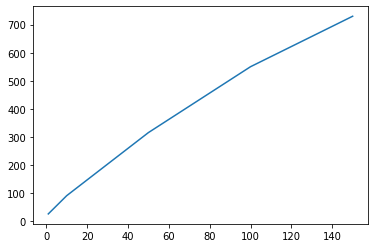

In [40]:
# drive conditions that produce the maximum amplitude signal
BIAS = 0.82
UNITY_AMPLITUDE = 0.1
FRAME_LENGTH = 0.0055
FRAME_RATE = 179
DAC_RATE = 781250
DAC_HOLD = 4
DAC_SMOOTH = 4
DAC_BANDWIDTH = DAC_RATE / DAC_HOLD / DAC_SMOOTH

DDS_VALS = [1, 10, 50, 100, 150]
DDS = [25, 90, 315, 550, 730]
plt.plot(DDS_VALS, DDS)

In [41]:
def write_to_c_array(data, holdcount=1):
    tablefile = open("table.c", "w")
    tablefile.write("#include <stdint.h>\n\n")
    tablefile.write(f'unsigned DRIVE_LUT_SIZE = {len(data) * holdcount};\n')
    tablefile.write(f'uint16_t DRIVE_LUT[{len(data) * holdcount}] = {"{"} \\')
    for index, val in enumerate(data):
        chunk = holdcount * f'{int(val)},'
        if index % 32:
            tablefile.write(chunk)
        else:
            tablefile.write(f'\n{chunk}')
    tablefile.write("\n};")
    tablefile.close()

In [42]:
def periodic_noise(N, P=1, gain=1, fs=1, process=None):
    if process is None:
        process = np.random.default_rng(123)

    k = process.integers(low=1, high=N, size=N-1)
    U = np.zeros(N * 2, dtype=np.complex128)

    # signal is real, so its spectrum is hermitian (negative frequencies are conjugate symmetric)
    samples = k / N * gain * np.exp(1j * 2 * np.pi * k / N)
    # create oscillator bank with dc value U[0] = 0
    U[1:N] = samples

    # create time domain signal
    u = 2 * np.sqrt(UNITY_AMPLITUDE) * np.real(np.fft.irfft(U))
    return u, U[:N]


In [43]:
def gaussian_noise(N, P=1, gain=1, process=None):
    if process is None:
        process = np.random.default_rng(123)

    k = process.integers(low=1, high=N, size=N-1)
    gshape = np.sqrt(2 * np.pi * k / N) * np.exp(-2 * np.pi**2 * (k / N)**2)
    plt.figure()
    plt.plot(gshape)
    U = np.zeros(N * 2, dtype=np.complex128)

    # signal is real, so its spectrum is hermitian (negative frequencies are conjugate symmetric)
    samples = gshape * gain * np.exp(1j * 2 * np.pi * k / N)
    # create oscillator bank with dc value U[0] = 0
    U[1:N] = samples

    # create time domain signal
    u = 2 * np.sqrt(UNITY_AMPLITUDE) * np.real(np.fft.irfft(U))
    return u, U[:N]


In [44]:
def oscillator_bank(N, freqs, amps, process=None):
	k = np.arange(N)
	harmonics = len(freqs)
	oscillators = [amp * np.sin(np.pi * freq * k) for freq, amp in zip(freqs, amps)]
	return np.sum(np.array(oscillators), axis=0)

776.0
-0.004048433082300299


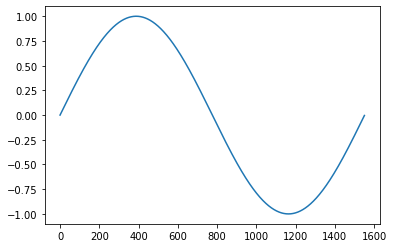

In [45]:
freq = 8e3
k = DAC_RATE // freq * 8
print(k)
sig = oscillator_bank(k*2, np.array([1/k]), np.array([1]))
print(sig[-1])
plt.figure()
plt.plot(sig)

In [55]:
def random_phase_multisine(N, P=1, gain=1, fs=1, process=None):
    '''
        N: number of samples in one signal period

        P: number of time domain periods to generate

        With a normalized amplitude spectrum, the DFT coefficient magnitudes U(k*fs/N) are scaled by 1/sqrt(N)
        U(k*fs/N) are uniformley bounded with a finite number of discontinuities on [0, fs/2].
        Further, the clock frequency fs is independent of N.

        Phase mean drawn from the random process must = 0
    '''

    if process is None:
        process = np.random.default_rng()

    k = process.integers(low=1, high=N-1, size=N-2)
    U = np.zeros(N - 1, dtype=np.complex128)

    # signal is real, so its spectrum is hermitian (negative frequencies are conjugate symmetric)
    samples = gain * np.exp(1j * 2 * np.pi * k / (N - 1))
    # create oscillator bank with dc value U[0] = 0
    U[1:] = samples

    Pu = N * P - 1
    # create time domain signal
    u = np.sqrt((N - 1) / 2 / np.pi) * np.real(np.fft.irfft(U))
    return u, U

1.0211638037908621
2044
1.0154020097534504


<BarContainer object of 1022 artists>

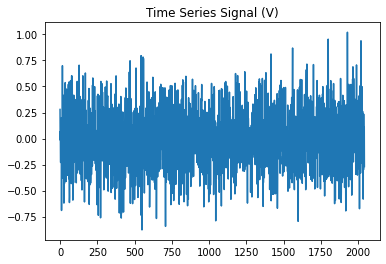

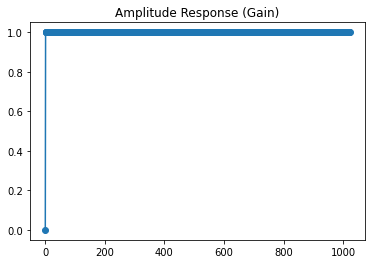

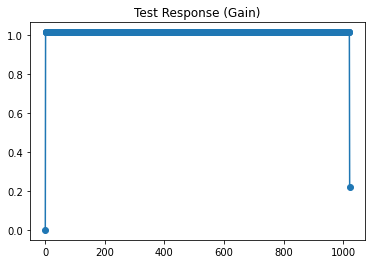

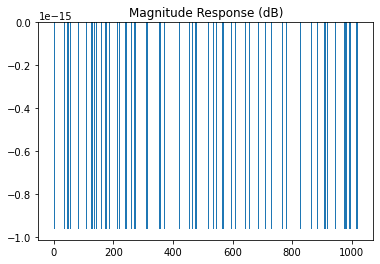

In [56]:
N = 1024
u, U = random_phase_multisine(N=N, P=2)
print(np.max(u))
print(len(u))
plt.figure()
plt.title('Time Series Signal (V)')
plt.plot(u)

plt.figure()
plt.title('Amplitude Response (Gain)')
plt.plot(np.abs(U), marker='o')

plt.figure()
plt.title('Test Response (Gain)')
checkfft = np.fft.rfft(u, n=len(u)) / (4 * np.pi)
print(np.abs(checkfft)[3])
plt.plot(np.abs(checkfft), marker='o')

plt.figure()
plt.title('Magnitude Response (dB)')
mag = 20 * np.log10(np.abs(U[1:]))
plt.bar(np.arange(len(mag)), mag)


2044


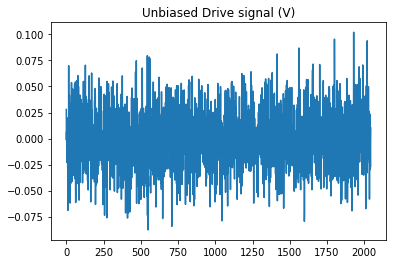

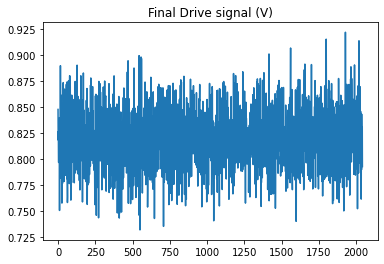

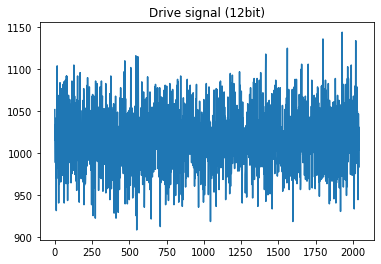

In [57]:

# transform to be output ready
u_out = u.copy()

u_out *= UNITY_AMPLITUDE

print(len(u_out))
plt.figure()
plt.title('Unbiased Drive signal (V)')
plt.plot(u_out)
u_out += BIAS
plt.figure()
plt.title('Final Drive signal (V)')
plt.plot(u_out)

dac_table = np.round(u_out * 4095 / 3.3)
plt.figure()
plt.title('Drive signal (12bit)')
plt.plot(dac_table)

write_to_c_array(dac_table, holdcount=DAC_HOLD)